In [1]:
import jax
import jax.numpy as np
import jraph
import flax.linen as nn
import numpy as onp
import matplotlib.pyplot as plt

from functools import partial

In [2]:
%load_ext autoreload
%autoreload 2

In [17]:
import sys
sys.path.append("../")

from models.gnn import GraphConvNet
from models.graph_utils import nearest_neighbors
from models.graph_utils import add_graphs_tuples
from models.graph_utils import rotate_representation

In [4]:
k = 2

In [9]:
n_nodes = 5000
n_features = 3
x = np.load("/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/halos.npy")[:, :n_nodes,:n_features]
x_mean = x.mean((0, 1))
x_std = x.std((0, 1))
x = (x - x.mean((0, 1))) / x.std((0, 1))

In [10]:
sources, targets = jax.vmap(nearest_neighbors, in_axes=(0, None))(x[:2], k)

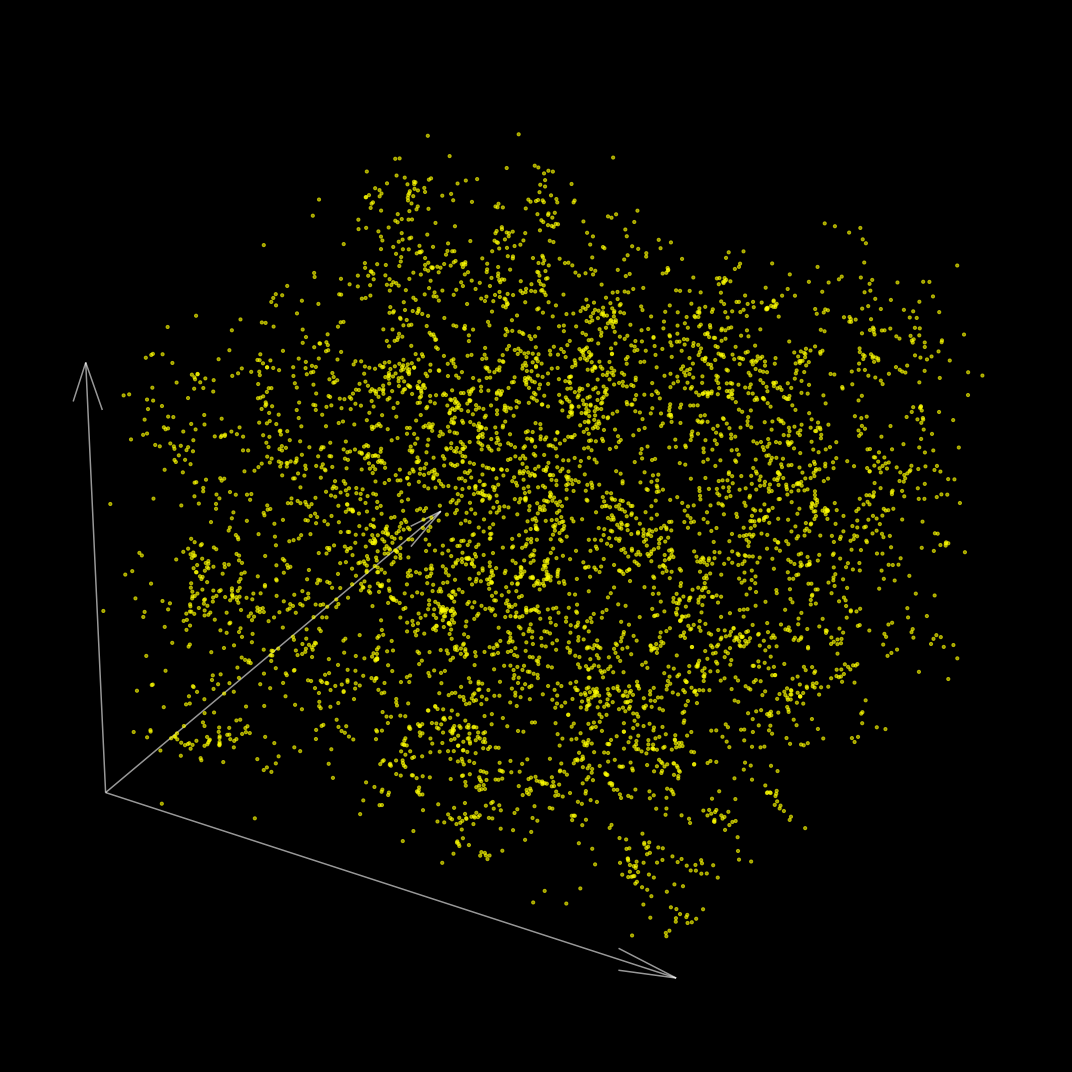

In [24]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(15, 15))

ax2 = fig.add_subplot(1, 1, 1, projection='3d')
ax2.clear()

# x_plot = x[0] * x_std[:n_features] + x_mean[:n_features]
x_plot = rotate_representation(x[0], 90., np.array([0.,0.,1.])) * x_std[:n_features] + x_mean[:n_features]

ax2.scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.6, s=10, color="yellow");

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

ax2.set_axis_off()

xx, yy, zz = np.zeros((3,3))
uu, vv, ww = 1000 * np.array([[1,0,0],[0,1,0],[0,0,1]])

ax2.quiver(xx,yy,zz,uu,vv,ww,arrow_length_ratio=0.1, color='white', alpha=0.6)

ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 1000)
ax2.set_zlim(0, 1000)

plt.tight_layout()
plt.savefig("plots/box_rot.pdf")

## EGNN

In [20]:
from models.egnn import EGNN

In [21]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(EGNN(
                        message_passing_steps=2, d_hidden=64, n_layers=3, norm_layer=False, skip_connections=False,
                ))
        return model(x)
    
model = GraphWrapper()
rng = jax.random.PRNGKey(42)

## Test equivariance

In [29]:
x[0:2, :, :].mean()

Array(-0.02763418, dtype=float32)

In [30]:
graph = jraph.GraphsTuple(
          n_node=np.array(2 * [[n_nodes]]), 
          n_edge=np.array(2 * [[k]]),
          nodes=x[0:2, :, :], 
          edges=None,
          globals=np.ones((2, 7)),
          senders=sources,
          receivers=targets)

graph_out, _ = model.init_with_output(rng, graph)

x_out = graph_out.nodes

# angle_deg = 45.
# axis = np.array([0, 1 / np.sqrt(2), 1 / np.sqrt(2)])

# x_out_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x_out, angle_deg, axis)

# graph = jraph.GraphsTuple(
#           n_node=np.array(4 * [[n_nodes]]), 
#           n_edge=np.array(4 * [[20]]),
#           nodes=jax.vmap(rotate_representation, in_axes=(0,None,None))(x[0:4, :, :], angle_deg, axis),
#           edges=None,
#           globals=np.ones((4, 7)),
#           senders=sources,
#           receivers=targets)

# graph_out, params = model.init_with_output(rng, graph)
# x_out = graph_out.nodes

(10000, 3) (10000, 3)
9.999999747378752e-06, 0.1639018952846527, 0.004286140203475952, 0.010372674092650414, 0, 0
9.999999747378752e-06, 0.1387040913105011, 0.004843058064579964, 0.009891417808830738, 0, 0
xi = [[-1.3431747   0.69791275  0.5173336 ]
 [-1.3431747   0.69791275  0.5173336 ]
 [-1.2569613   0.19712499  0.8546246 ]
 [-1.2569613   0.19712499  0.8546246 ]], xj = [[-1.3431747   0.69791275  0.5173336 ]
 [-1.3624048   0.73487276  0.59879994]
 [-1.2569613   0.19712499  0.8546246 ]
 [-1.1319507   0.129373    0.7826721 ]]
xi = [[ 1.3988305  -0.5641771  -0.9211032 ]
 [ 1.3988305  -0.5641771  -0.9211032 ]
 [-1.5120885  -0.82699275 -1.1872464 ]
 [-1.5120885  -0.82699275 -1.1872464 ]], xj = [[ 1.3988305  -0.5641771  -0.9211032 ]
 [ 1.3891298  -0.5820746  -0.9488721 ]
 [-1.5120885  -0.82699275 -1.1872464 ]
 [-1.5106488  -0.85067636 -1.1264129 ]]
ms = [[9.9999997e-06]
 [8.3825998e-03]
 [9.9999997e-06]
 ...
 [2.5418238e-03]
 [9.9999997e-06]
 [1.0701774e-03]]
ms = [[9.9999997e-06]
 [1.19553

In [216]:
x_out

Array([[[-1.3431026 ,  0.6977741 ,  0.5170281 ],
        [-1.2569613 ,  0.19712499,  0.8546246 ],
        [-1.3875916 , -0.8728659 ,  1.4972426 ],
        ...,
        [ 0.18373454,  1.2345939 , -0.6831903 ],
        [-0.9477546 ,  0.6116089 ,  0.8896691 ],
        [ 0.61301965, -1.5020003 , -0.81670284]],

       [[ 1.3977916 , -0.5644693 , -0.92110085],
        [-1.5121626 , -0.8270542 , -1.1871569 ],
        [-1.1794705 , -0.09353735,  0.25352487],
        ...,
        [ 0.18224306,  1.2358471 , -0.6751533 ],
        [-0.9510068 ,  0.6147899 ,  0.89066786],
        [ 0.6084203 , -1.5031998 , -0.81584805]]], dtype=float32)

In [92]:
# plt.hist(onp.array(x_out)[0,:,2])

In [93]:
# Equivariance ratio
eq_ratio = x_out / x_out_rot
print(eq_ratio.max(), eq_ratio.min(), eq_ratio)

20.295788 -7.051834 [[[ 1.0008166   1.0008724   0.999304  ]
  [ 1.0008503   1.0005685   1.000457  ]
  [ 0.99155265  0.9978411   0.99908423]
  ...
  [ 1.0001603   0.9993249   0.99925137]
  [ 0.9889371   0.99885225  0.99559397]
  [ 0.9864263   1.0003259   1.0027362 ]]

 [[ 0.9991339   0.9994029   0.9991387 ]
  [ 0.99895686  0.99927497  1.0007412 ]
  [ 1.0004698   1.0016893   1.0144402 ]
  ...
  [ 1.0006037   0.98780954  1.0003967 ]
  [ 0.9956347   0.99795693  1.0007982 ]
  [-0.8481864   1.0002426   1.0030551 ]]

 [[ 1.0004767   1.0000732   1.0003489 ]
  [ 1.0294195   1.0052049   0.57948416]
  [ 1.0051254   0.99525446  1.0029076 ]
  ...
  [ 1.0045681   0.99976003  0.98984253]
  [ 0.9997207   1.0006992   0.99946576]
  [ 0.9994839   0.99905413  0.9848319 ]]

 [[ 1.0067011   0.9998752   0.9987213 ]
  [ 0.9998024   1.0002029   1.000398  ]
  [ 0.99177223  0.9998248   1.0002543 ]
  ...
  [ 0.99944764  1.0020063   1.0002644 ]
  [ 0.9997483   0.9973999   1.000468  ]
  [ 1.0003804   0.9888876   0.

In [346]:
sum(x.size for x in jax.tree_util.tree_leaves(params))

34308

In [347]:
from clu import parameter_overview
print(parameter_overview.get_parameter_overview(params))

+------------------------------------+----------+-------+-----------+-------+
| Name                               | Shape    | Size  | Mean      | Std   |
+------------------------------------+----------+-------+-----------+-------+
| params/EGNN_0/MLP_0/Dense_0/bias   | (64,)    | 64    | 0.0       | 0.0   |
| params/EGNN_0/MLP_0/Dense_0/kernel | (2, 64)  | 128   | 0.0302    | 0.675 |
| params/EGNN_0/MLP_0/Dense_1/bias   | (64,)    | 64    | 0.0       | 0.0   |
| params/EGNN_0/MLP_0/Dense_1/kernel | (64, 64) | 4,096 | 0.00124   | 0.126 |
| params/EGNN_0/MLP_0/Dense_2/bias   | (64,)    | 64    | 0.0       | 0.0   |
| params/EGNN_0/MLP_0/Dense_2/kernel | (64, 64) | 4,096 | -0.000354 | 0.124 |
| params/EGNN_0/MLP_0/Dense_3/bias   | (1,)     | 1     | 0.0       | 0.0   |
| params/EGNN_0/MLP_0/Dense_3/kernel | (64, 1)  | 64    | -0.0182   | 0.124 |
| params/EGNN_0/MLP_1/Dense_0/bias   | (64,)    | 64    | 0.0       | 0.0   |
| params/EGNN_0/MLP_1/Dense_0/kernel | (2, 64)  | 128   | -0.003